# Imputing Fare

In [43]:
#load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Note4:
Pclass is obviously a great variable to estimate fare. This time, ticket can actually help predicting the fare. But the pattern of ticket numbering should be known. Cabin number can also help as fare can vary depending upon quality of cabin. I can not use age as I have already used fare to estimate age. Also embarked port can help here.

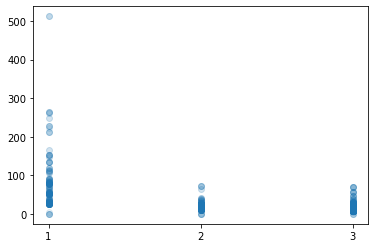

In [6]:
# start by looking at pclass
plt.scatter(data.Pclass, data.Fare, alpha=0.1)
_ = plt.xticks([1, 2, 3])

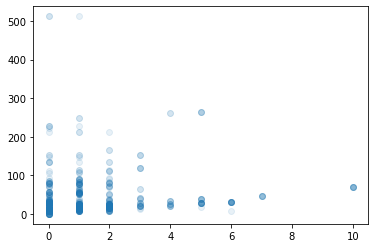

In [44]:
data['fam_n_frnd'] = data.SibSp + data.Parch

plt.scatter('fam_n_frnd', 'Fare', data=data, alpha=0.1)

In [9]:
sum(data.Fare > 450)

3

In [11]:
print(f'unique tickets = {data.Ticket.unique().shape}\nunique fares = {data.Fare.unique().shape}')

unique tickets = (681,)
unique fares = (248,)


([<matplotlib.axis.YTick at 0x2599cb183c8>,
 <a list of 3 Text major ticklabel objects>)

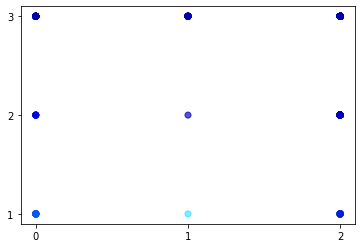

In [34]:
plt.scatter(x='Embarked', y='Pclass', data=data[~data.Embarked.isnull()], alpha=0.3,
            c='Fare', cmap=plt.get_cmap('jet'))
plt.xticks([0.0, 1.0, 2.0])
plt.yticks([1.0, 2.0, 3.0])


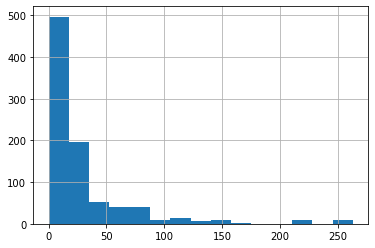

In [21]:
data.Fare.hist(bins=15)

In [36]:
sum(data.Embarked.isnull())

2

In [45]:
#cleaning and preprocessing

import re
from sklearn.preprocessing import OrdinalEncoder

pat = re.compile(r'^[A-Z]')
def cabin_cat(x):
    return pat.match(x).group()

#fill nan values
data['Cabin'] = data.Cabin.fillna('Z')
#replace cabin with cabin type
data['Cabin'] = data.Cabin.apply(cabin_cat)
#ignore outliers, although Embarked can be predicted using simple decision tree on Tickets
data = data[(~data.Embarked.isnull()) & (data.Fare < 400)] 
#encode variables
ord_en = OrdinalEncoder()
data[['Cabin', 'Embarked', 'Sex']] = ord_en.fit_transform(data[['Cabin', 'Embarked', 'Sex']])
#final variables
X = data[['Pclass', 'fam_n_frnd', 'Sex', 'Cabin', 'Embarked']]
y = data['Fare']

In [46]:
#train model
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

param_grid = [
    {'n_estimators': np.arange(30, 130, step=20),
     'max_depth': [2, 3, 4, 5], 
     'max_leaf_nodes': np.arange(3, 13)
    },
]

xgb = XGBRegressor()

grids = GridSearchCV(xgb, param_grid, scoring="neg_mean_squared_error", return_train_score=True, cv=5)
grids.fit(X, y)

joblib.dump(grids.best_estimator_, 'filename.pkl')
grids.best_params_

{'max_depth': 3, 'max_leaf_nodes': 3, 'n_estimators': 30}

-542.5744277605058


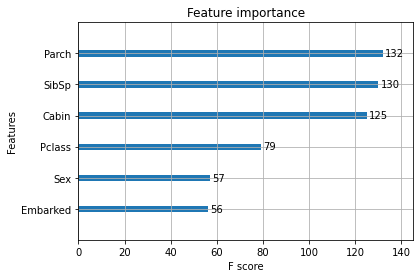

In [41]:
from xgboost import plot_importance

plot_importance(grids.best_estimator_)
print(grids.best_score_)